# 数値的逆運動学入門

数値的逆運動学は任意のロボットアームの逆運動学をロバストに求めることができる非常に有用な技術です。本ノートブックではリー群・リー代数を用いて特異点回避を考慮した数値的逆運動学を解くために必要な技術的な内容について解説します。

In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## 1. DHパラメータと順運動学

### DHパラメータ

DHパラメータは軸数分の($\theta$, d, a, $\alpha$)からなるパラメータで、それぞれのパラメータは以下の同次変換に対応します。
- $\theta$ : Z軸回りの回転(関節角度)
- d : Z軸方向の変位
- a : X軸方向の変位
- $\alpha$ : X軸方向の回転

各パラメータの同次変換行列は以下のようになります。

$$
T_\theta = 
\begin{bmatrix}
\cos\theta & -\sin\theta & 0 & 0 \\
\sin\theta & \cos\theta & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

$$
T_d = 
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & d \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

$$
T_a = 
\begin{bmatrix}
0 & 0 & 0 & a \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

$$
T_\alpha = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & \cos\alpha & -\sin\alpha & 0 \\
0 & \sin\alpha & \cos\alpha & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

これを順番に掛けていくと、ある軸での同次変換行列ができます。

$$
T_{joint_n} = T_\theta T_d T_a T_\alpha
 =
\begin{bmatrix}
\cos\theta & -\sin\theta*\cos\alpha & \sin\theta*\sin\alpha & a*\cos\theta \\
\sin\theta & \cos\theta*\cos\alpha & -\cos\theta*\sin\alpha & a*\sin\theta \\
0 & \sin\alpha & \cos\alpha & d \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

### 順運動学

$\theta$に各軸の関節角度を代入し、各軸での同次変換行列を順番に掛けていくと手先の同次変換行列ができます。これにより各軸の関節角度から手先の姿勢を計算することができます。これが順運動学(Forward Kinematics)です。
$$
T_{fk} = T_{joint1} T_{joint2} T_{joint3} T_{joint4} T_{joint5} T_{joint6}
$$

### 実装

Pythonで書くとこうなります。DHパラメータはX-TrainerのソースコードからNova2のDHパラメータを取ってきました。

In [14]:
# Nova2のDHパラメータ
dh_params = [
    (0, 0.2234, 0, np.pi / 2),
    (0 - np.pi / 2, 0, -0.280, 0),
    (0, 0, -0.225, 0),
    (0 - np.pi / 2, 0.1175, 0, np.pi / 2),
    (0, 0.120, 0, -np.pi / 2),
    (0, 0.088, 0, 0)
]

# 各軸の同次変換行列
def dh_transform(theta, d, a, alpha):
    ct, st = np.cos(theta), np.sin(theta)
    ca, sa = np.cos(alpha), np.sin(alpha)
    return np.array([
        [ct, -st*ca, st*sa, a*ct],
        [st, ct*ca, -ct*sa, a*st],
        [0, sa, ca, d],
        [0, 0, 0, 1]
])

# FK
def fk(q, dh_params):
    """forward kinematics

    Args:
        q : joint positions array
        dh_params : DH parameters

    Returns:
        T : Transformation matrix
    """
    T = np.eye(4)
    for i, (theta0, d, a, alpha) in enumerate(dh_params):
       T = T @ dh_transform(q[i] + theta0, d, a, alpha)
    return T

## 2.逆運動学の全体像

関節角度から手先の姿勢を求める計算を順運動学というのに対し、手先の目標姿勢$\bm{pose}$からその姿勢を実現するための関節角度$\bm{q}$を求める計算を逆運動学(Inverse Kinematics)といいます。

$$
\bm{q} = [q_1, q_2, ... , q_n]^T
$$
$$
\bm{pose} = f(\bm{q}) : 順運動学
$$
$$
\bm{q} = f^{-1}(\bm{pose}) : 逆運動学
$$

こうして見ると、順運動学の式を連立方程式として$\theta$について解けば逆運動学が求められそうな気がしますが、この連立方程式は非線形なうえにそもそも解が存在しない場合があったり特異点  が存在したりと、解くのが非常に難しいです。そこで6軸ロボットアームでは解析的解法または数値的解法で逆運動学を求めます。

### 解析的解法

解析的解法では順運動学の式をめっちゃうまく式変形して$\theta$について解くことで逆運動学を求めます。あとそもそもそのような式変形ができるようにアーム自体を設計したりします。
例えば456番目のジョイントの軸が交わるような軸配置の6軸ロボットでは手先の位置と回転を別々に求める式変形(Pieperの方法)が知られており、AgileX PiPERやUnitree Z1/D1などはPieperの方法が使えるように軸配置が設計されています。本ノートブックでは扱わないので詳しくは参考文献を参照してください。

- pros
  - 数値的解法とは異なり反復計算なしで一発で計算できるため高速。
  - 数値誤差や初期値に依存しないため再現性が高い。
  - 全ての解が求まるのでElbow up/downなどの姿勢が指定できる。
- cons
  - ロボットの軸配置に依存するので汎用性が低い。
  - 特異点を考慮できないので特異姿勢に近づくと止まるか暴走する。
  - 一発で計算するので柔軟性が低い。

### 数値的解法

数値的解法では、「①初期姿勢と目標姿勢の誤差を求める」「②その差が小さくなるように関節角度を更新する」の二つを反復計算することで目標姿勢を実現するための関節角度を求めます。最も基本的な解法はヤコビ行列を用いた反復法です。CLIK(Closed Loop Inverse Kinematics)やニュートン・ラフソン法と呼ばれることが多いです。

#### ヤコビ行列とは

ヤコビ行列は関節角度ベクトルを$\bm{q} = [q_1, q_2, ... , q_n]^T$、手先姿勢ベクトルを$\bm{x} = [x_1, x_2, .., x_n]$とすると以下のように定義されます。

$$
J(\bm{q}) = \partial \bm{x} / \partial \bm{q} = 
\begin{bmatrix}
\partial x_1 / \partial q_1 & \dots & \partial x_1 / \partial q_n \\
\vdots & \ddots & \vdots \\
\partial x_n / \partial q_1 & \dots & \partial x_n / \partial q_n
\end{bmatrix}
$$

ヤコビ行列は$\bm{q}$の微小変化に対する$\bm{x}$の変化であり、関節角度と手先姿勢を関連付ける行列です。

#### ヤコビアンを用いた反復法

$\bm{q}$から$\bm{x}$を求める順運動学の式は連立非線形方程式でしたが、$\dot{\bm{q}}$と$\dot{\bm{x}}$の関係はヤコビアンを用いると以下のように線形に表せます。

$$
\dot{\bm{x}} = J(\bm{q})\dot{\bm{q}}
$$

これは微分のチェーンルールが成り立つためです。確認してみてください。

ヤコビアンの逆行列$J(\bm{q})^{-1}$を使うと$\bm{x}$の微小変化に対する$\bm{q}$の微小変化を求めることができます。

$$
\dot{\bm{q}} = J(\bm{q})^{-1}\dot{\bm{x}}
$$

ただしヤコビアンの逆行列は存在しないことがたまによくあるので実際は疑似逆行列を用います。

$$
\dot{\bm{q}} = J(\bm{q})^\dagger\dot{\bm{x}} \\
J^\dagger = (J^TJ)^{-1}J^T
$$

これでヤコビアンを用いた反復法を行う準備ができました。
1. 目標姿勢と現在の姿勢の誤差を求めます。
   $$
   \dot{\bm{x}} = \bm{x_{target}} - \bm{x_{current}}
   $$
2. ヤコビアンの疑似逆行列と誤差から$\bm{q}$の微小変化を求め、その値を用いて誤差が十分低くなるまで$\bm{q}$を更新します。

  $$
  \bm{q} = \bm{q} + \dot{\bm{q}} \\
  = \bm{q} + J(\bm{q})^\dagger\dot{\bm{x}} \\
  = \bm{q} + J(\bm{q})^\dagger * (\bm{x_{target}} - \bm{x_{current}})
  $$

- pros
  - 任意のロボットアームに使えるので汎用性が高い。
  - 特異点回避を組み込めるのでロバスト。
  - 最適化を組み込めるので柔軟性が高い。
- cons
  - 反復計算が必要なので解析的解法よりも遅い。
  - 解が初期値に依存する。

## 3.数値的逆運動学とリー群・リー代数

先ほど求めた数値的逆運動学には問題があります。

$$
\dot{\bm{x}} = \bm{x_{target}} - \bm{x_{current}}
$$

当たり前のように手先姿勢ベクトル同士を引き算して微小変化を求めていますが、一般的に姿勢同士の微小変化を求めるのは簡単ではありません。これは回転が非線形なうえにジンバルロック等により連続でないためです。リー群・リー代数を使うとこの問題が解決できます。

### リー群・リー代数

私はリー群・リー代数の数学的背景についてよくわかっていない上にもう時間がないので本ノートでは使い方のみにフォーカスします。数学的背景については

#### リー群・リー代数とは

リー群とは多様体の構造をもった群です。多様体の構造を持っているので単位元まわりの接空間を定義することができ、その接空間をリー代数といいます。
私は多様体も群もよくわからないのでこう理解しています。多分実用上は問題ない気がします。
- リー群:連続で0点周りの微小変化を定義できる群。
- リー代数:リー群の微小変化。線形で計算しやすい。

リー群とリー代数は相互変換が可能です。リー代数はリー群の微小変化であり、積分見たいに重ね掛けするとリー群に変換することができます。この変換(写像)を指数写像と呼び、その逆変換を対数写像と呼びます。
- 指数写像：リー代数->リー群
- 対数写像：リー群->リー代数

回転行列を元とする群(SO(3))や同次変換行列を元とする群(SE(3))はリー群です。リー群に対するリー代数は小文字で書かれます。(SO(3)/so(3))

回転行列や同次変換行列がリー群であることを利用すると、数値的逆運動学ような姿勢の微小変化を求める計算が以下のように非常に簡単になります。

1. 姿勢の差を求める($T^{-1}T$)
2. 姿勢の差を対数写像でリー代数に変換。
3. リー代数の線形性を利用すると数値計算や最適化がめっちゃ簡単になる！嬉しい！
4. 指数写像で姿勢に戻して結果を取得する。

#### SO(3)/so(3)

3次元回転行列を元とする群(SO(3))である三次元特殊直交群(3D Special Orthlogical group)はリー群です。SO(3)のリー代数so(3)は歪対象行列になります。

SO(3)
$$
R_{xyz} = R_x R_y R_z \\
$$
so(3)
$$
[\bm{\omega}]_\times = 
\begin{bmatrix}
0 & -\omega_z & \omega_y \\
\omega_z & 0 & -\omega_x \\
-\omega_y & \omega_x & 0
\end{bmatrix}
$$

この式は$R_{xyz}$の式を$\cos(a) \approx 1$、$\sin(a) \approx a$、$\sin(a)\sin(b) \approx 0$で近似すると出てきます。やってみてください。

また$[\bm{\omega}]_\times$は以下の3次元の回転ベクトルと同型なので3次元ベクトルとして計算できます。

$$
\bm{\omega} = [\omega_x, \omega_y, \omega_z]^T
$$

$\bm{\omega}$から$R_{xyz}$への指数写像はロドリゲスの回転公式で近似できます。対数写像は歪対象行列を用いて逆変換します。Pythonでの実装は以下の通りです。

In [15]:
def log_so3(R):
    theta = np.arccos((np.trace(R) -1)/2)
    if abs(theta) < 1e-6:
        return np.zeros(3)
    else:
        w_hat = (R - R.T)/(2*np.sin(theta))
        w = np.array([w_hat[2,1], w_hat[0,2], w_hat[1,0]])
        if theta > np.pi:
            w *= (theta - 2 * np.pi) / theta
        return theta * w/np.linalg.norm(w)

def skew_symmetric(w):
    return np.array([[0, -w[2], w[1]], [w[2], 0, -w[0]], [-w[1], w[0], 0]])

def exp_so3(w):
    theta = np.linalg.norm(w)
    if theta < 1e-6:
        return np.eye(3)
    W = skew_symmetric(w/theta)
    R = np.eye(3) + np.sin(theta)*W + (1 - np.cos(theta))*(W@W)
    return R

In [16]:
R = np.array([[0, -1, 0],[1, 0, 0],[0,0,1]])
w = log_so3(R)
print(np.rad2deg(w))
R = exp_so3(w)
print(np.round(R,2))

[ 0.  0. 90.]
[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]


#### SE(3)/se(3)

同次変換行列をを元とする群(SE(3))である**特殊ユークリッド群(Special Euclidean group)**もリー群です。

SE(3)
$$
T =
\begin{bmatrix}
R_{xyz} & t \\
0  & 1
\end{bmatrix}
$$

se(3)
$$
\xi = 
\begin{bmatrix}
\bm{\omega_{xyz}} & \bm{t} \\
0  & 1
\end{bmatrix}
$$

$\xi$も6次元のベクトルと同型なのでベクトルとして計算できます。

$$
\bm{\xi} = [\bm{\omega_{xyz}} , \bm{t}]^T
$$

指数写像と対数写像はロドリゲスとか歪対象行列を使って近似できます。Pythonで実装するとこんな感じです。

In [17]:
def exp_se3(xi):
    w, v = xi[:3], xi[3:]
    theta = np.linalg.norm(w)
    if theta < 1e-6:
        R = np.eye(3)
        V = np.eye(3)
    else:
        w_hat = w / theta
        W = skew_symmetric(w_hat)
        R = np.eye(3) + np.sin(theta) * W + (1 - np.cos(theta)) * (W @ W)
        V = np.eye(3) + (1 - np.cos(theta)) / theta * W + (theta - np.sin(theta)) / theta**2 * (W @ W)
    p = V @ v
    T = np.eye(4)
    T[:3, :3], T[:3, 3] = R, p
    return T

def log_se3(T):
    R, p = T[:3, :3], T[:3, 3]
    theta = np.arccos(np.clip((np.trace(R) - 1) / 2, -1.0, 1.0))
    if abs(theta) < 1e-6:
        w, v = np.zeros(3), p
    else:
        w_hat = (R - R.T) / (2 * np.sin(theta))
        w = theta * np.array([w_hat[2, 1], w_hat[0, 2], w_hat[1, 0]])
        W = skew_symmetric(w / theta)
        V = np.eye(3) + (1 - np.cos(theta)) / theta * W + (theta - np.sin(theta)) / theta**2 * (W @ W)
        V_inv = np.linalg.inv(V)
        v = V_inv @ p
    
    return np.concatenate([w, v])

In [18]:
T = np.array([[0, -1, 0, 1],[1, 0, 0, 1],[0, 0, 1, 1], [0, 0, 0, 1]])
xi = log_se3(T)
print(np.rad2deg(xi[:3]))
T_dash = exp_se3(xi)
print(np.round(T_dash, 2))

[ 0.  0. 90.]
[[ 0. -1.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 0.  0.  1.  1.]
 [ 0.  0.  0.  1.]]


### SE(3)を用いたヤコビ行列の定義

SE(3)を使うとこのようにヤコビ行列を簡潔に定義できます。

In [19]:
def compute_jacobian_se3(q, dh_params, delta=1e-6):
    n_joints = len(q)
    J = np.zeros((6, n_joints))
    T0 = fk(q, dh_params)
    for i in range(n_joints):
        q_perturbed = q.copy()
        q_perturbed[i] += delta
        T1 = fk(q_perturbed, dh_params)
        T_error = np.linalg.inv(T0) @ T1
        xi = log_se3(T_error) / delta
        J[:, i] = xi
    return J

### SE(3)を用いた数値的逆運動学

SE(3)を用いて2章で紹介したヤコビ行列を用いた反復法を実装すると以下のようになります。初期値を与えて動かしてみましょう。

In [20]:
# ヤコビ行列を用いた反復法
def clik_se3(target_T, dh_params, q_init, max_iter=100, tol=2e-3):
    q = q_init.copy()
    q_history = [q.copy()]
    for i in range(max_iter):
        current_T = fk(q, dh_params)
        dT = np.linalg.inv(current_T) @ target_T
        xi = log_se3(dT)
        if np.linalg.norm(xi) < tol:
            print(f"IK solved!")
            return q, q_history
        J = compute_jacobian_se3(q, dh_params)
        J_pinv = np.linalg.pinv(J)
        dq = J_pinv @ xi
        q += np.clip(dq, -0.1, 0.1)
        q_history.append(q.copy())
    print("IK not solved.")
    return q, q_history

In [21]:
# 可視化
def get_link_pos(q, dh_params):
    positions = [np.array([0,0,0])]
    T = np.eye(4)
    for i, (theta0, d, a, alpha) in enumerate(dh_params):
        T = T @ dh_transform(q[i] + theta0, d, a, alpha)
        pos = T[:3, 3].copy()
        positions.append(pos)
    return np.array(positions)

def visualize_robot(q_history, dh_params, target_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([target_p[0]],[target_p[1]], [target_p[2]], color='r', label='Target')
    
    def update(frame):
        ax.cla()
        q = q_history[frame]
        positions = get_link_pos(q, dh_params)
        ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], marker='o', label='Robot')
        ax.scatter([target_p[0]],[target_p[1]], [target_p[2]], color='r', label='Target')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_zlim(0, 1)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        ax.set_title(f"Iteration: {frame}")
    ani = FuncAnimation(fig, update, frames=len(q_history), interval=200, repeat=False)
    # plt.show()
    return ani

IK solved!
calc time: 0.4065265655517578


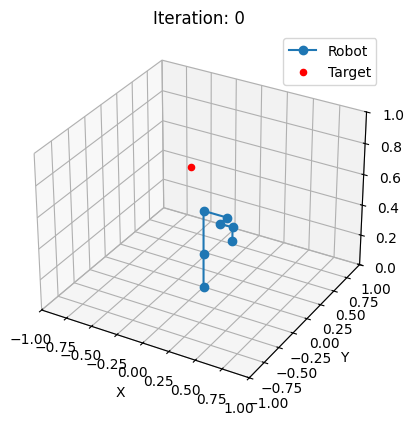

In [30]:
# q_init = np.array([0.0,0,0,0,0,0])
# target_T = fk(np.array([0, 0, -np.pi/2, 0, np.pi/2, np.pi/2]), dh_params)
q_init = np.array([0, 0, -np.pi/2, 0, np.pi/2, np.pi/2])
target_T = fk(np.array([0.0,0,0,0,0,0]), dh_params)
target_p = target_T[:3, 3]
start = time.time()
q_se3, q_se3_history = clik_se3(target_T, dh_params, q_init)
stop = time.time()
print(f"calc time: {stop - start}")
ani_se3 = visualize_robot(q_se3_history, dh_params, target_p)
HTML(ani_se3.to_jshtml())

#### 特異点回避

最後に数値的逆運動学の利点である特異点回避をやってみます。普通の反復法では疑似逆行列を使っていますが、この疑似逆行列は特異点付近でランク落ちすることがあるのでダンピング稿を加えることでそれを防いでみます。この手法は**ダンピング最小二乗法(damped least square)**や**Lebenberg-Marquartd法**などと呼ばれます。式は以下の通りです。

$$
J_{damped}^\dagger = (J^TJ + \lambda I)^{-1}J^T
$$

In [31]:
def clik_dls(target_T, dh_params, q_init, lambda_sq = 0.0001, max_iter=100, tol=1e-3):
    q = q_init.copy()
    q_history = [q.copy()]
    for i in range(max_iter):
        T_current = fk(q, dh_params)
        T_error = np.linalg.inv(T_current) @ target_T
        xi = log_se3(T_error)
        if np.linalg.norm(xi) < tol:
            print("IK solved!")
            return q, q_history
        J = compute_jacobian_se3(q, dh_params)
        J_pinv_dls = J.T @ np.linalg.inv(J @ J.T + lambda_sq * np.eye(6))
        dq = J_pinv_dls @ xi
        q += np.clip(dq, -0.1, 0.1)
        q_history.append(q.copy())
    print("IK not solved.")
    return q, q_history

IK solved!
calc time: 0.09255528450012207


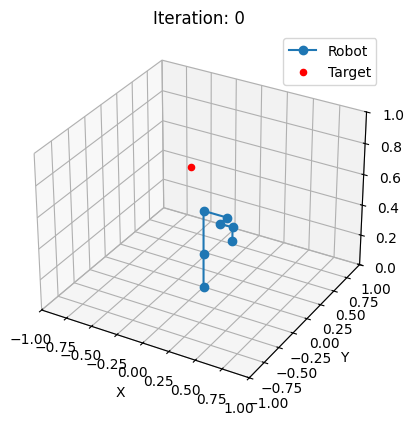

: 

In [32]:
start = time.time()
q_dls, q_dls_history = clik_dls(target_T, dh_params, q_init)
stop = time.time()
print(f"calc time: {stop - start}")
anim_dls = visualize_robot(q_dls_history, dh_params, target_p)
HTML(anim_dls.to_jshtml())

## 参考文献

- リー群・リー代数
  - https://qiita.com/scomup/items/fa9aed8870585e865117
    - 指数写像・対数写像の導出とかはこれを見てください。とってもわかりやすい。
- 疑似逆行列
  - https://www.momoyama-usagi.com/entry/math-linear-algebra-ap09
    - 疑似逆行列と最小二乗法の関係がわかります。線形代数全般はこのサイトがおすすめ。
- Levenberg Marquartd法
  - https://kamino.hatenablog.com/entry/lm_method
- 順運動学・逆運動学全般
  - 英語：https://hades.mech.northwestern.edu/images/7/7f/MR.pdf
  - 日本語：https://amzn.asia/d/dtjDFn9
    - Pieperの方法はここに載ってました。
- お好きな生成AI
  - このコードをお好きな生成AIに与えて追加の質問するといいかもしれません。私はGrokに質問しながらこのノートを作りました。
    - 「ダンピング最小二乗法以外の特異点回避方法のサンプルを実装して」
    - 「リー群を使う利点について教えて」